# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print 'Running tests with p = ', p
  print 'Mean of input: ', x.mean()
  print 'Mean of train-time output: ', out.mean()
  print 'Mean of test-time output: ', out_test.mean()
  print 'Fraction of train-time output set to zero: ', (out == 0).mean()
  print 'Fraction of test-time output set to zero: ', (out_test == 0).mean()
  print

Running tests with p =  0.3
Mean of input:  9.997744032252166
Mean of train-time output:  9.97926027277733
Mean of test-time output:  9.997744032252166
Fraction of train-time output set to zero:  0.70048
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  9.997744032252166
Mean of train-time output:  9.974759426954053
Mean of test-time output:  9.997744032252166
Fraction of train-time output set to zero:  0.401368
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  9.997744032252166
Mean of train-time output:  9.978610772897113
Mean of test-time output:  9.997744032252166
Fraction of train-time output set to zero:  0.251324
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print 'dx relative error: ', rel_error(dx, dx_num)

dx relative error:  5.445611072277256e-11


# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [22]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print 'Running check with dropout = ', dropout
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))
#     print("calculated")
#     print(grad_num)
#     print("expected")
#     print(grads[name])

  print

Running check with dropout =  0
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505173 -0.02012555  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58579142e-03  8.48913567e-04  0.00000000e+00
  7.71318620e-03  6.78430173e-05  0.00000000e+00 -1.14767882e-02
 -2.19708072e-03  0.00000000e+00  9.37097339e-03  9.12598301e-03
  1.39147962e-03 -1.22497941e-02  1.16806696e-02  0.00000000e+00
  1.61940592e-03  3.00230414e-03  0.00000000e+00 -1.04924542e-02]
Initial loss:  0.0
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.02

#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854113  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505173 -0.02012555  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58579146e-03  8.48913590e-04  0.00000000e+00
  7.71318616e-03  6.78429740e-05  0.00000000e+00 -1.14767881e-02
 -2.19708064e-03  0.00000000e+00  9.37097335e-03  9.12598298e-03
  1.39147970e-03 -1.22497940e-02  1.16806693e-02  0.00000000e+00
  1.61940578e-03  3.00230427e-03  0.00000000e+00 -1.04924540e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.0150

#######db_last - 1 #######
[ 0.00000000e+00  1.58579142e-03  8.48913072e-04  0.00000000e+00
  7.71318676e-03  6.78432035e-05  0.00000000e+00 -1.14767884e-02
 -2.19708072e-03  0.00000000e+00  9.37097329e-03  9.12598300e-03
  1.39147933e-03 -1.22497944e-02  1.16806696e-02  0.00000000e+00
  1.61940592e-03  3.00230414e-03  0.00000000e+00 -1.04924546e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505173 -0.02012555  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58579142e-03  8.48913567e-04  0.00000000e+00
  7.71318620e-03  6.78430173e-05  0.00000000e+00 -1.14767882e-02
 -2.19708072e-03  0.00000000e+00  9.37097339e-03  9.12598301e-03
  1.39147962e-03 -1.22497941e-02  1.16806696e-02

#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505173 -0.02012555  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58579142e-03  8.48913567e-04  0.00000000e+00
  7.71318620e-03  6.78430173e-05  0.00000000e+00 -1.14767882e-02
 -2.19708072e-03  0.00000000e+00  9.37097339e-03  9.12598301e-03
  1.39147962e-03 -1.22497941e-02  1.16806696e-02  0.00000000e+00
  1.61940592e-03  3.00230414e-03  0.00000000e+00 -1.04924542e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.0150

#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854113  0.         -0.01200784
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505172 -0.02012554  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58579142e-03  8.48914003e-04  0.00000000e+00
  7.71298500e-03  6.78430271e-05  0.00000000e+00 -1.14767879e-02
 -2.19708072e-03  0.00000000e+00  9.37097321e-03  9.12598327e-03
  1.39147982e-03 -1.22497935e-02  1.16806696e-02  0.00000000e+00
  1.61940592e-03  3.00230414e-03  0.00000000e+00 -1.04924541e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.0559341   0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059955  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.0150

#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505173 -0.02012555  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58579142e-03  8.48913567e-04  0.00000000e+00
  7.71318620e-03  6.78430173e-05  0.00000000e+00 -1.14767882e-02
 -2.19708072e-03  0.00000000e+00  9.37097339e-03  9.12598301e-03
  1.39147962e-03 -1.22497941e-02  1.16806696e-02  0.00000000e+00
  1.61940592e-03  3.00230414e-03  0.00000000e+00 -1.04924542e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.0150

  1.61940592e-03  3.00230414e-03  0.00000000e+00 -1.04924543e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854113  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.0583073  -0.07326434 -0.01505172 -0.02012554  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58579142e-03  8.48914054e-04  0.00000000e+00
  7.71318512e-03  6.78430010e-05  0.00000000e+00 -1.14767874e-02
 -2.19708072e-03  0.00000000e+00  9.37097370e-03  9.12598309e-03
  1.39114386e-03 -1.22497931e-02  1.16806696e-02  0.00000000e+00
  1.61940592e-03  3.00230414e-03  0.00000000e+00 -1.04924539e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.0559341   0.          0.         -0.01557836  0.          0.
  0.1050998   0.03059955  0.          0

[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505173 -0.02012555  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58579142e-03  8.48913567e-04  0.00000000e+00
  7.71318620e-03  6.78430173e-05  0.00000000e+00 -1.14767882e-02
 -2.19708072e-03  0.00000000e+00  9.37097339e-03  9.12598301e-03
  1.39147962e-03 -1.22497941e-02  1.16806696e-02  0.00000000e+00
  1.61940592e-03  3.00230414e-03  0.00000000e+00 -1.04924542e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505173 -0.02012555  0.0391318

#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505173 -0.02012555  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58579144e-03  8.48913567e-04  0.00000000e+00
  7.71318620e-03  6.78430173e-05  0.00000000e+00 -1.14767882e-02
 -2.19708069e-03  0.00000000e+00  9.37097339e-03  9.12598301e-03
  1.39147962e-03 -1.22497941e-02  1.16806696e-02  0.00000000e+00
  1.61940596e-03  3.00230417e-03  0.00000000e+00 -1.04924822e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.0150

[ 0.00000000e+00  1.58579799e-03  8.48920963e-04  0.00000000e+00
  7.71322132e-03  6.78254412e-05  0.00000000e+00 -1.14767674e-02
 -2.19704286e-03  0.00000000e+00  9.37103694e-03  9.12601264e-03
  1.39148923e-03 -1.22498142e-02  1.16806661e-02  0.00000000e+00
  1.61943152e-03  3.00234834e-03  0.00000000e+00 -1.04924960e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516761  0.01854114  0.         -0.01200785
 -0.0559341   0.          0.         -0.01557936  0.          0.
  0.10509979  0.03059955  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505172 -0.02012555  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975448  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58578485e-03  8.48906172e-04  0.00000000e+00
  7.71315107e-03  6.78605935e-05  0.00000000e+00 -1.14768090e-02
 -2.19711857e-03  0.00000000e+00  9.37090983e-03  9.12595337e-03
  1.39147001e-03 -1.22497740e-02  1.16806730e-02  0.00000000e+00
  1.619380

#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.0559341   0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059955  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505273 -0.02012555  0.03913183  0.
 -0.03445519  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58576379e-03  8.48920341e-04  0.00000000e+00
  7.71321432e-03  6.78251479e-05  0.00000000e+00 -1.14766839e-02
 -2.19705748e-03  0.00000000e+00  9.37093570e-03  9.12593972e-03
  1.39146368e-03 -1.22498487e-02  1.16806610e-02  0.00000000e+00
  1.61939993e-03  3.00229407e-03  0.00000000e+00 -1.04924539e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854113  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.0150

[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059955  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505173 -0.02012555  0.03913183  0.
 -0.03445518  0.0173053  -0.00779614  0.03537059 -0.02975447  0.        ]
#######db_last - 1 #######
[ 0.00000000e+00  1.58579142e-03  8.48913567e-04  0.00000000e+00
  7.71318620e-03  6.78430173e-05  0.00000000e+00 -1.14767880e-02
 -2.19708065e-03  0.00000000e+00  9.37097356e-03  9.12598296e-03
  1.39147962e-03 -1.22497941e-02  1.16806696e-02  0.00000000e+00
  1.61940641e-03  3.00230408e-03  0.00000000e+00 -1.04924543e-02]
#######db_last - 2 #######
[ 0.00266984  0.         -0.02516762  0.01854114  0.         -0.01200785
 -0.05593409  0.          0.         -0.01557836  0.          0.
  0.10509979  0.03059956  0.          0.00766482 -0.0223603  -0.00279252
  0.05830731 -0.07326434 -0.01505173 -0.02012555  0.0391318

[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875759  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.  

#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last -

  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.0327848   0.          0.          0.         -0.15641181
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0

#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last -

#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last -

#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last -

#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last -

[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.

#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last -

#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last -

[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.00369584  0.          0.          0.
  0.         -0.00666246  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
#######db_last - 2 #######
[-0.06875757  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03278479  0.          0.          0.         -0.1564118
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
#######db_last - 1 #######
[ 0.          0.

#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486986  0.04687195 -0.06192368  0.
 -0.01269803 -0.0196216   0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123434  0.05665583  0.03265673 -0.0695146   0.

[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 

  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269804 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123434  0.05665583  

[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 

#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.

#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.

[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 

  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.00574519  0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.0196216   0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214293
  0.00057437 -0.0161616   0.00880988 -0.00849931 -0.00203046 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.0196216   0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  

  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_las

#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.

#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.0250117   0.          0.         -0.00115759
  0.          0.          0.00481571  0.         -0.00507154  0.01214294
  0.00057437 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059741
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269803 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695146   0.

#######db_last - 1 #######
[ 0.          0.         -0.02501158  0.          0.         -0.00115759
  0.          0.          0.00481568  0.         -0.00507161  0.01214294
  0.00057435 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059736
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.         -0.04008644
  0.          0.          0.02486985  0.04687195 -0.06192368  0.
 -0.01269804 -0.01962161  0.          0.          0.          0.
  0.          0.          0.0571571   0.          0.          0.
  0.          0.04123433  0.05665583  0.03265673 -0.0695156   0.        ]
#######db_last - 1 #######
[ 0.          0.         -0.02501181  0.          0.         -0.00115759
  0.          0.          0.00481574  0.         -0.00507147  0.01214294
  0.00057439 -0.0161616   0.00880988 -0.00849919 -0.00203045 -0.00059747
  0.          0.        ]
#######db_last - 2 #######
[ 0.          0.0057452   0.04784171  0.          0.        

# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [6]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print dropout

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 0.000000
(Epoch 0 / 25) train acc: 0.224000; val_acc: 0.183000


cs231n/layers.py:694: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


(Epoch 1 / 25) train acc: 0.382000; val_acc: 0.219000
(Epoch 2 / 25) train acc: 0.484000; val_acc: 0.248000
(Epoch 3 / 25) train acc: 0.620000; val_acc: 0.275000
(Epoch 4 / 25) train acc: 0.654000; val_acc: 0.245000
(Epoch 5 / 25) train acc: 0.724000; val_acc: 0.280000
(Epoch 6 / 25) train acc: 0.788000; val_acc: 0.301000
(Epoch 7 / 25) train acc: 0.814000; val_acc: 0.260000
(Epoch 8 / 25) train acc: 0.836000; val_acc: 0.268000
(Epoch 9 / 25) train acc: 0.906000; val_acc: 0.287000
(Epoch 10 / 25) train acc: 0.934000; val_acc: 0.292000
(Epoch 11 / 25) train acc: 0.960000; val_acc: 0.258000
(Epoch 12 / 25) train acc: 0.928000; val_acc: 0.268000
(Epoch 13 / 25) train acc: 0.956000; val_acc: 0.275000
(Epoch 14 / 25) train acc: 0.942000; val_acc: 0.266000
(Epoch 15 / 25) train acc: 0.976000; val_acc: 0.284000
(Epoch 16 / 25) train acc: 0.984000; val_acc: 0.292000
(Epoch 17 / 25) train acc: 0.984000; val_acc: 0.286000
(Epoch 18 / 25) train acc: 0.994000; val_acc: 0.282000
(Epoch 19 / 25) tra

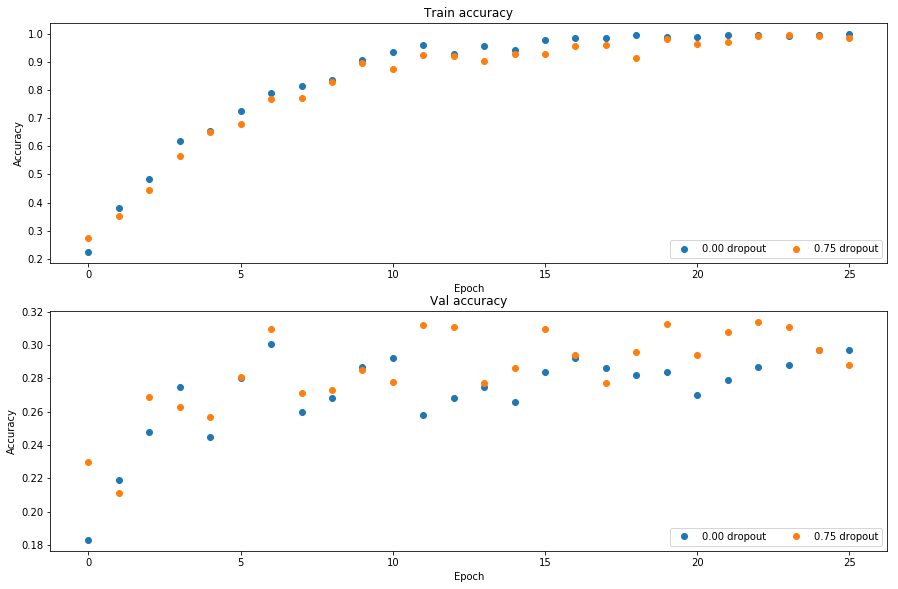

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question
Explain what you see in this experiment. What does it suggest about dropout?

# Answer
